This is my Nth attempt at getting at a neat and flexible workflow to reliably isolate FM and CF in a horseshoebat CF call. 

2020-03-03 00:20 Some rather useful ideas:

> LOW + HIGH pass filter around CF
> get the RMS profile of the CF and RMs
> choose a threshold such that the number of sampels that share both a CF and FM label is minimised. 


-- Thejasvi Beleyur 2020-03-02 on ICE 1700 to Berlin

In [1]:
import scipy.signal as signal 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000

In [2]:
%matplotlib notebook

In [3]:
import sys 
sys.path.append('../measure_horseshoe_bat_calls/')

In [4]:

import pandas as pd
from measure_a_horseshoe_bat_call import make_one_CFcall, measure_hbc_call, make_overview_figure
from measure_a_horseshoe_bat_call import get_peak_frequency, remove_frequency, dB, moving_rms

### The logic of it all:
I want to basically get back to some old ideas and mix+match them with some new ones:

* 1) Lowpass to get the FM, Highpass to the get CF 
* 2) Compare which regions show the most drop in energy/rms
* 3) Isolate the areas with the highest difference in energy/rms across 

In [5]:
fs = 500000.0
peak_f = 100000.0
fm_durn = 0.005
cf_durn = 0.050
call_parameter = (cf_durn, fm_durn, peak_f, 40000, 0)

cf_durn, fm_durn, peak_f, fm_bw, _ = call_parameter
eg_call =  make_one_CFcall(cf_durn+fm_durn, fm_durn, cf_freq=peak_f, fs=fs,
                                                           call_shape='staplepin',
                                                           fm_bandwidth=fm_bw)
eg_call += np.random.normal(0,10**-60/20.0, eg_call.size)
pad_length = int(0.1*fs)
padded_call = np.pad(eg_call, [pad_length]*2, mode='constant', constant_values=(0,0))

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


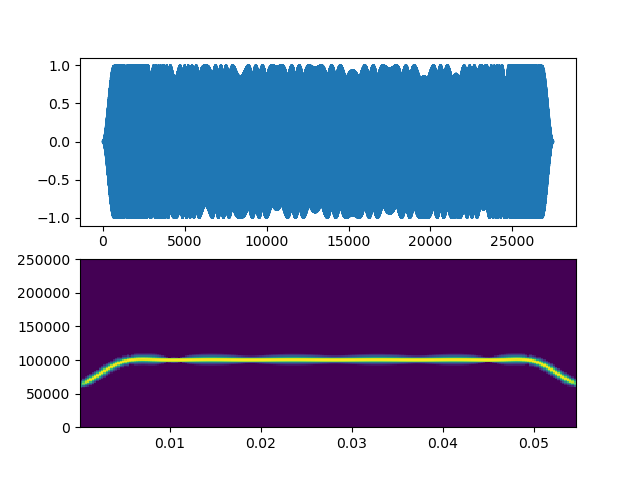

In [6]:
plt.figure()
plt.subplot(211)
plt.plot(eg_call)
plt.subplot(212)
plt.specgram(eg_call, Fs=fs, vmin=-90);

In [7]:
help(signal.cheby1)

Help on function cheby1 in module scipy.signal.filter_design:

cheby1(N, rp, Wn, btype='low', analog=False, output='ba', fs=None)
    Chebyshev type I digital and analog filter design.
    
    Design an Nth-order digital or analog Chebyshev type I filter and
    return the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    rp : float
        The maximum ripple allowed below unity gain in the passband.
        Specified in decibels, as a positive number.
    Wn : array_like
        A scalar or length-2 sequence giving the critical frequencies.
        For Type I filters, this is the point in the transition band at which
        the gain first drops below -`rp`.
    
        For digital filters, `Wn` are in the same units as `fs`.  By default,
        `fs` is 2 half-cycles/sample, so these are normalized from 0 to 1,
        where 1 is the Nyquist frequency.  (`Wn` is thus in
        half-cycles / sample.)
    
        For analog fil

In [8]:
percent_peak = 0.99
lowpass = signal.ellip(4,3,10, peak_f*percent_peak/(0.5*fs), 'lowpass')
highpass = signal.ellip(4,3,10, peak_f*percent_peak/(0.5*fs), 'highpass')

In [9]:
call_only_fm = signal.filtfilt(lowpass[0], lowpass[1], padded_call)
call_only_cf = signal.filtfilt(highpass[0], highpass[1], padded_call)

<IPython.core.display.Javascript object>


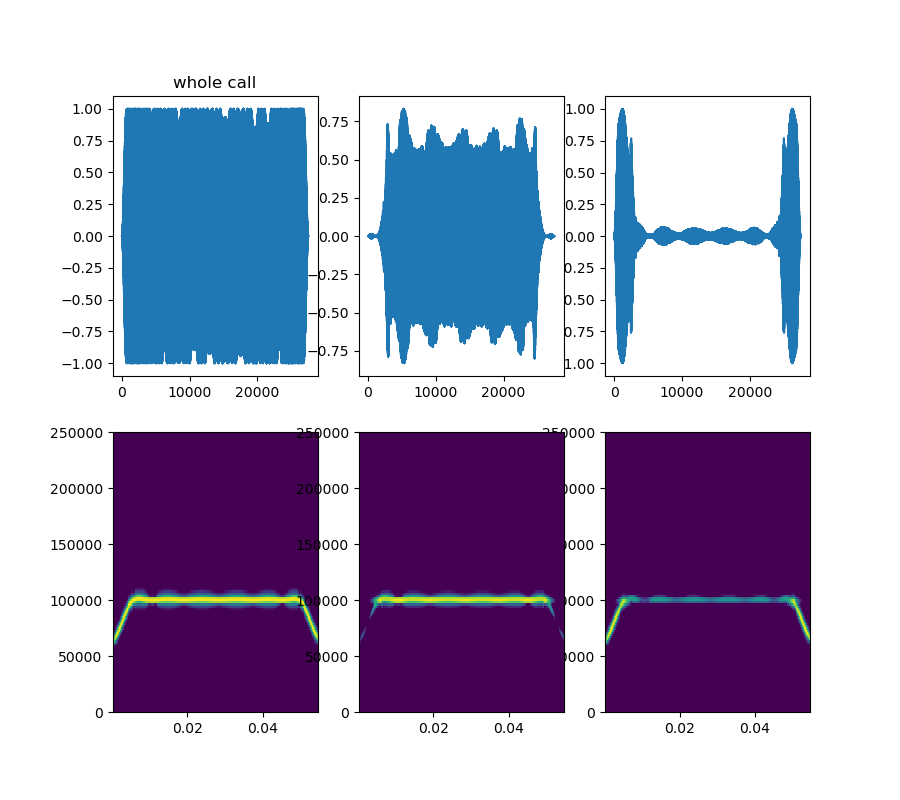

In [10]:
plt.figure(figsize=(9,8))
plt.subplot(231)
plt.title('whole call')
plt.plot(eg_call)
plt.subplot(234)
plt.specgram(eg_call, Fs=fs, vmin=-90);



plt.subplot(233)
plt.plot(call_only_fm[pad_length:-pad_length])
plt.subplot(236)
plt.specgram(call_only_fm[pad_length:-pad_length], Fs=fs, vmin=-90);

plt.subplot(232)
plt.plot(call_only_cf[pad_length:-pad_length])
plt.subplot(235)
plt.specgram(call_only_cf[pad_length:-pad_length], Fs=fs, vmin=-90);



In [11]:
def frontback_convolve(X, y):
    once = signal.convolve(X,y, 'same')
    once_flip = np.flip(once)
    once_flip_convolve = signal.convolve(once_flip,y, 'same')
    back_again = np.flip(once_flip_convolve)
    return back_again


In [12]:
winsize = int(fs*0.25*10**-3)
call_rms = moving_rms(eg_call,window_size=winsize)
fm_rms = moving_rms(call_only_fm[pad_length:-pad_length],window_size=winsize)
cf_rms = moving_rms(call_only_cf[pad_length:-pad_length],window_size=winsize)

# smooth the rms to remove fluctuations
fm_rms_smoothed  = frontback_convolve(fm_rms.flatten(), signal.hanning(500))
cf_rms_smoothed = frontback_convolve(cf_rms.flatten(), signal.hanning(500))

call_dbrms = dB(call_rms)
fm_dbrms =  dB(fm_rms)
cf_dbrms = dB(cf_rms)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  import sys
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


In [13]:
def draw_percentile_line(X, pctile=5):
    threshold = np.percentile(X, pctile)
    plt.hlines(threshold, 0, X.size)
    return threshold

In [42]:
def make_threshold_plot(cf_dbrms, fm_dbrms, fs):
    threshold = np.arange(10,90)
    common_samples = []
    total_fm_samples = []
    total_cf_samples = []
    for each in threshold:
        fm_samples = fm_dbrms >= np.percentile(fm_dbrms, each)
        cf_samples = cf_dbrms >= np.percentile(cf_dbrms, 100-each)
        cf_and_fm_samples = np.sum(np.logical_and(fm_samples, cf_samples))

        total_fm_samples.append(np.sum(fm_samples))
        total_cf_samples.append(np.sum(cf_samples))
        common_samples.append(cf_and_fm_samples)
    
    # now choose threshold which minimises sample overlap and maximises number of fm+cf durations!
    threshold_for_least_common = threshold[np.argmin(common_samples)]
    total_durns = np.array(total_cf_samples)+np.array(total_fm_samples)
    threshold_for_maximum_durns = threshold[np.argmax(total_durns)]
    optimum_threshold = threshold_for_least_common*0.05 + threshold_for_maximum_durns*0.95
    print(threshold_for_least_common, threshold_for_maximum_durns)
    return optimum_threshold, [common_samples, total_durns], threshold        

In [43]:
o_thr,metric, thresholds = make_threshold_plot(fm_dbrms, cf_dbrms, fs)

89 82


In [44]:
o_thr

82.35

<IPython.core.display.Javascript object>


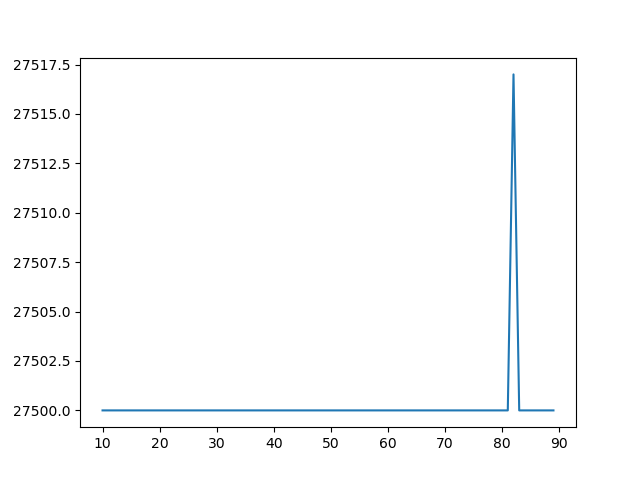

In [45]:
plt.figure()
#plt.plot(thresholds, metric[0])
plt.plot(thresholds, metric[1])
#plt.plot(o_thr, metric[int(np.argwhere(thresholds==o_thr)[0])],'*')
#plt.hlines(metric[int(np.argwhere(thresholds==o_thr)[0])],0,thresholds.size)


<IPython.core.display.Javascript object>


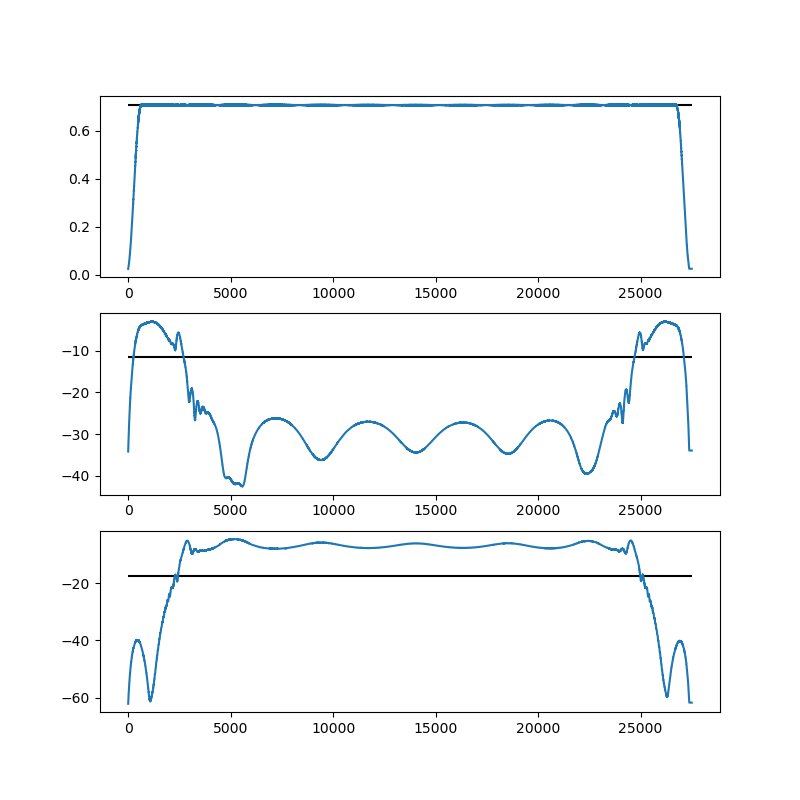

In [46]:
thresh = o_thr
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(call_rms)
draw_percentile_line(call_rms, o_thr)
plt.subplot(312)
plt.plot(fm_dbrms)
fm_thresh = draw_percentile_line(fm_dbrms,o_thr)

plt.subplot(313)
plt.plot(cf_dbrms)
cf_thresh = draw_percentile_line(cf_dbrms, 100-o_thr)


In [56]:
estim_fm_durn = np.sum(fm_dbrms>=fm_thresh)/fs
estim_cf_durn = np.sum(cf_dbrms>=cf_thresh)/fs

print(estim_cf_durn, estim_fm_durn/2, estim_cf_durn+estim_fm_durn)

0.045292 0.004854 0.055


In [57]:
print(cf_durn, fm_durn, cf_durn+fm_durn*2 )

0.05 0.005 0.060000000000000005
